In [1]:
# Imports
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Load the .mat file
data = scipy.io.loadmat('data/condsForSimJ2moMuscles.mat')

# Extract condsForSim struct
conds_for_sim = data['condsForSim']

In [3]:
# Initialize lists to store data for all conditions
go_envelope_all = []
plan_all = []
muscle_all = []

# Get the number of conditions (rows) and delay durations (columns)
num_conditions, num_delays = conds_for_sim.shape

# Loop through each condition and extract data
for i in range(num_conditions):  # 27 conditions
    go_envelope_condition = []
    plan_condition = []
    muscle_condition = []

    for j in range(num_delays):  # 8 delay durations
        condition = conds_for_sim[i, j]

        go_envelope = condition['goEnvelope']
        plan = condition['plan']
        muscle = condition['muscle']

        # Select only muscles 5 and 6 
        selected_muscle_data = muscle[:, [4, 5]]  # Select columns for muscle 5 and 6, which show the nicest multiphasic activity

        go_envelope_condition.append(go_envelope)
        plan_condition.append(plan)
        muscle_condition.append(selected_muscle_data)

    # Stack data for each condition
    go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))
    plan_all.append(torch.tensor(plan_condition, dtype=torch.float32))
    muscle_all.append(torch.tensor(muscle_condition, dtype=torch.float32))

# Stack data for all conditions
go_envelope_tensor = torch.stack(go_envelope_all)
plan_tensor = torch.stack(plan_all)
muscle_tensor = torch.stack(muscle_all)

# Reshape to merge the first two dimensions
go_envelope_tensor = go_envelope_tensor.reshape(-1, *go_envelope_tensor.shape[2:])
plan_tensor = plan_tensor.reshape(-1, *plan_tensor.shape[2:])
muscle_tensor = muscle_tensor.reshape(-1, *muscle_tensor.shape[2:])

# Print shapes
print(f"Go Envelope Tensor Shape: {go_envelope_tensor.shape}")
print(f"Plan Tensor Shape: {plan_tensor.shape}")
print(f"Muscle Tensor Shape: {muscle_tensor.shape}")


/tmp/ipykernel_268751/1417502240.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  go_envelope_all.append(torch.tensor(go_envelope_condition, dtype=torch.float32))


Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Plan Tensor Shape: torch.Size([216, 296, 15])
Muscle Tensor Shape: torch.Size([216, 296, 2])


In [4]:
# Normalize and standardize a tensor
def normalize_and_standardize(tensor):
    # Normalize: Scale to 0-1 range
    min_val = tensor.min()
    max_val = tensor.max()
    tensor = (tensor - min_val) / (max_val - min_val)

    # Standardize: Shift to zero mean and unit variance
    mean = tensor.mean()
    std = tensor.std()
    tensor = (tensor - mean) / std

    return tensor

# Apply the function to each tensor
normalized_go_envelope_tensor = normalize_and_standardize(go_envelope_tensor)
normalized_plan_tensor = normalize_and_standardize(plan_tensor)
normalized_muscle_tensor = normalize_and_standardize(muscle_tensor)

# Print shapes to confirm
print(f"Normalized Go Envelope Tensor Shape: {normalized_go_envelope_tensor.shape}")
print(f"Normalized Plan Tensor Shape: {normalized_plan_tensor.shape}")
print(f"Normalized Muscle Tensor Shape: {normalized_muscle_tensor.shape}")


Normalized Go Envelope Tensor Shape: torch.Size([216, 296, 1])
Normalized Plan Tensor Shape: torch.Size([216, 296, 15])
Normalized Muscle Tensor Shape: torch.Size([216, 296, 2])


In [5]:
import torch
import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant

        # Weight initialization
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
        self.bx = nn.Parameter(torch.zeros(hidden_size))
        self.bz = nn.Parameter(torch.zeros(output_size))

        # Nonlinearity
        self.nonlinearity = torch.tanh
    
    def forward(self, x, hidden):
        timestep = self.tau / 10  # Timestep for Euler integration
        for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
            hidden_update = torch.matmul(self.J, hidden.T)
            input_update = torch.matmul(self.B, x.T)
            new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
            new_hidden = new_hidden.T

            # Euler integration for continuous-time update
            hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
        output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
        output = output.T
        return output, hidden
    
    def init_hidden(self):
        # Initialize hidden state with an additional batch dimension
        return torch.zeros(1, self.hidden_size)

# Hyperparameters
input_size = 7  
hidden_size = 300
output_size = 2  # Number of muscles
g = 1.1  # g value
h = 1.0  # h value

# Model instantiation
model = SimpleRNN(input_size, hidden_size, output_size, g, h)


In [6]:
import torch
import torch.nn as nn

class ComplicatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, g, h, tau=50):
        super(ComplicatedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.tau = tau  # Time constant

        # Modified weight initialization for a more chaotic regime (g >> 1)
        # Adjust the scale factor as per the specific requirements of the model
        self.J = nn.Parameter(torch.randn(hidden_size, hidden_size) * (g / torch.sqrt(torch.tensor(hidden_size, dtype=torch.float))))
        self.B = nn.Parameter(torch.randn(hidden_size, input_size) * (h / torch.sqrt(torch.tensor(input_size, dtype=torch.float)))) 
        self.w = nn.Parameter(torch.zeros(output_size, hidden_size))
        self.bx = nn.Parameter(torch.zeros(hidden_size))
        self.bz = nn.Parameter(torch.zeros(output_size))

        # Nonlinearity remains the same
        self.nonlinearity = torch.tanh
    
    def forward(self, x, hidden):
        timestep = self.tau / 10  # Timestep for Euler integration
        for _ in range(int(1 / timestep)):  # Adjust the range for simulation duration
            hidden_update = torch.matmul(self.J, hidden.T)
            input_update = torch.matmul(self.B, x.T)
            new_hidden = self.nonlinearity(hidden_update + input_update + self.bx.unsqueeze(1))
            new_hidden = new_hidden.T

            # Euler integration for continuous-time update
            hidden = hidden + (timestep / self.tau) * (-hidden + new_hidden)
        
        output = torch.matmul(self.w, hidden.T) + self.bz.unsqueeze(1)
        output = output.T
    
        return output, hidden

    def init_hidden(self):
        # Initialize hidden state with an additional batch dimension
        return torch.zeros(1, self.hidden_size)

input_size = 7
hidden_size = 300
output_size = 2 # Number of muscles
g = 10.0 # Significantly larger g value for complicated model
h = 1.0 # h value remains the same

complicated_model = ComplicatedRNN(input_size, hidden_size, output_size, g, h)

In [7]:
# Prepare data for training
# Assuming that 'normalized_plan_tensor' is your input data and 'normalized_muscle_tensor' is your target data
X_train = normalized_plan_tensor
y_train = normalized_muscle_tensor

In [8]:
# Convert datasets to TensorDataset and DataLoader for batch processing
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64  # You can adjust this based on your data size and memory constraints
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [9]:
# Loss Function and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/samuele/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/samuele/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Loss: 0.7935759276151657
Epoch 2, Loss: 0.6920289844274521
Epoch 3, Loss: 0.7398229837417603
Epoch 4, Loss: 0.6482370048761368
Epoch 5, Loss: 0.6573842614889145
Epoch 6, Loss: 0.7131140679121017
Epoch 7, Loss: 0.7308777570724487
Epoch 8, Loss: 0.6652112305164337
Epoch 9, Loss: 0.667251855134964
Epoch 10, Loss: 0.6554328501224518
Epoch 11, Loss: 0.6719786077737808
Epoch 12, Loss: 0.6412559151649475
Epoch 13, Loss: 0.6577332764863968
Epoch 14, Loss: 0.6826722845435143
Epoch 15, Loss: 0.6730566173791885
Epoch 16, Loss: 0.6750237941741943
Epoch 17, Loss: 0.6717002838850021
Epoch 18, Loss: 0.6032176986336708
Epoch 19, Loss: 0.6918650567531586
Epoch 20, Loss: 0.6837166324257851
Epoch 21, Loss: 0.6371837109327316
Epoch 22, Loss: 0.6939346790313721
Epoch 23, Loss: 0.6163643524050713
Epoch 24, Loss: 0.6930471509695053
Epoch 25, Loss: 0.6808096617460251
Epoch 26, Loss: 0.6641812026500702
Epoch 27, Loss: 0.7106741070747375
Epoch 28, Loss: 0.644190602004528
Epoch 29, Loss: 0.5723693408071

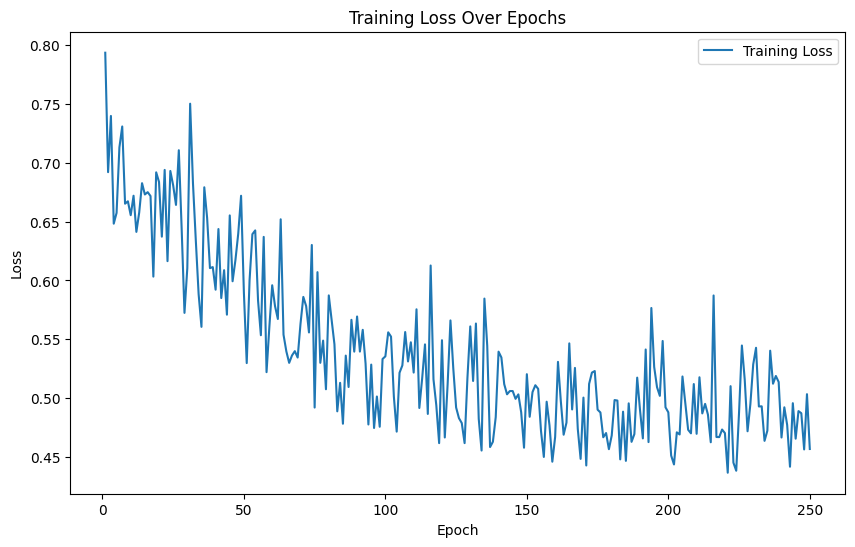

In [10]:
import matplotlib.pyplot as plt

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        h = model.init_hidden()

        # Process each time step
        for t in range(inputs.shape[1]):  # iterate over time steps
            output, h = model(inputs[:, t, :], h)

        # Compute loss using the last output (if your task is many-to-one)
        loss = criterion(output, targets[:, -1, :])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


Epoch 1, Loss: 0.7205749005079269
Epoch 2, Loss: 0.6714087128639221
Epoch 3, Loss: 0.6538456007838249
Epoch 4, Loss: 0.6780925467610359
Epoch 5, Loss: 0.6583075970411301
Epoch 6, Loss: 0.760643795132637
Epoch 7, Loss: 0.7337100505828857
Epoch 8, Loss: 0.7637397348880768
Epoch 9, Loss: 0.6507012248039246
Epoch 10, Loss: 0.6706947758793831
Epoch 11, Loss: 0.7026693820953369
Epoch 12, Loss: 0.7958869636058807
Epoch 13, Loss: 0.7023506462574005
Epoch 14, Loss: 0.7687423676252365
Epoch 15, Loss: 0.7000135183334351
Epoch 16, Loss: 0.6597461774945259
Epoch 17, Loss: 0.7268760949373245
Epoch 18, Loss: 0.7524468153715134
Epoch 19, Loss: 0.7063141465187073
Epoch 20, Loss: 0.7392593324184418
Epoch 21, Loss: 0.7214491367340088
Epoch 22, Loss: 0.754235178232193
Epoch 23, Loss: 0.7253281325101852
Epoch 24, Loss: 0.696549654006958
Epoch 25, Loss: 0.8609312176704407
Epoch 26, Loss: 0.6951945871114731
Epoch 27, Loss: 0.69309501349926
Epoch 28, Loss: 0.7275056838989258
Epoch 29, Loss: 0.796893760561943


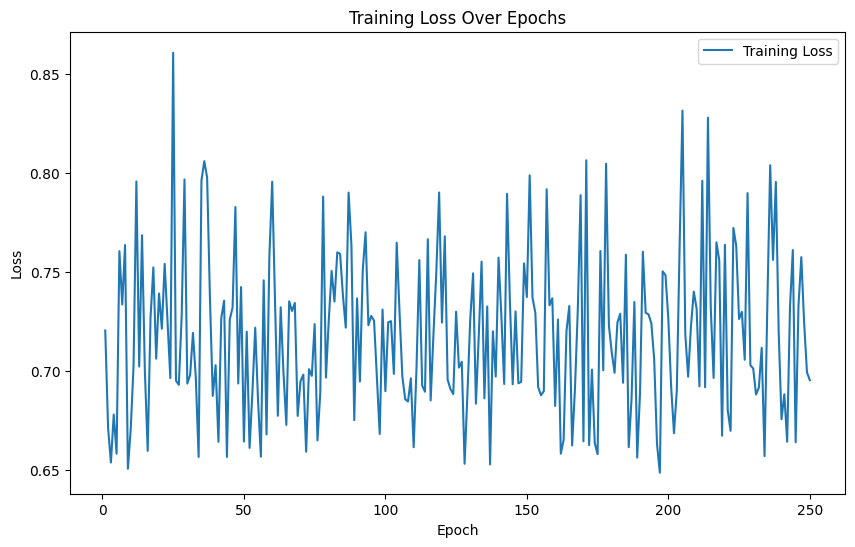

In [11]:
import matplotlib.pyplot as plt

# Training Loop
num_epochs = 250  # The number of times the entire dataset is passed through the network
epoch_losses = []  # List to store average loss of each epoch

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        h = model.init_hidden()

        # Process each time step
        for t in range(inputs.shape[1]):  # iterate over time steps
            output, h = complicated_model(inputs[:, t, :], h)

        # Compute loss using the last output (if your task is many-to-one)
        loss = criterion(output, targets[:, -1, :])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

print('Finished Training')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
